# Speck Masking Notebook

The following block initializes the chipwhisperer, as always

In [1]:
import chipwhisperer as cw
import time

In [2]:
# Path to the Speck .hex file for reflashing
PATH="/home/msc/documents/obsidian_notes/master-aits/subjects/implementation_attacks_and_countermeasures/praktikum/speck_cpa_cw/cw_firmware/simple-speck-CWLITEARM.hex"
PATH="/home/juan/documents/master-aits/subjects/implementation_attacks_and_countermeasures/praktikum/speck_cpa_cw/cw_firmware/simple-speck-CWLITEARM.hex"
PATH="/home/juan/documents/master-aits/subjects/implementation_attacks_and_countermeasures/praktikum/speck_cpa_cw/cw_firmware_masked/simple-speck-CWLITEARM.hex"
PATH="/home/msc/documents/obsidian_notes/master-aits/subjects/implementation_attacks_and_countermeasures/praktikum/speck_cpa_cw/cw_firmware_hiding/simple-speck-CWLITEARM.hex"

In [57]:
scope.dis()

In [3]:
def flash(scope, prog):
    cw.program_target(scope, prog, PATH)

def reset_target(scope):
    scope.io.nrst = 'low'
    time.sleep(0.05)
    scope.io.nrst = 'high_z'
    time.sleep(0.05)

try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()

try:
    target = cw.target(scope)
except IOError:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope)

print("INFO: Found ChipWhisperer😍")

prog = cw.programmers.STM32FProgrammer
time.sleep(0.05)
scope.default_setup()

INFO: Found ChipWhisperer😍


**Reset the target if required:**

In [4]:
reset_target(scope)

**Reflash the target if required:**

In [5]:
flash(scope, prog)

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 10563 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 10563 bytes


**Set an encryption key:**

In [6]:
# 32 bytes of encryption key
#encryption_key = b"\x00\x01\x02\x03\x04\x05\x06\x07\x08\x09\x0a\x0b\x0c\x0d\x0e\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1c\x1d\x1e\x1f"

# 8 byte encryption key
encryption_key = b"\x11\x22\x33\x44\x55\x66\x77\x88"
if len(encryption_key) == 8:
    target.simpleserial_write("s", encryption_key)

**Get the encryption key:**

In [7]:
target.simpleserial_write("k", b'\x00'*4)
print(target.simpleserial_read("o", 8))

CWbytearray(b'11 22 33 44 55 66 77 88')


**Encrypt a 4-byte block:**

In [8]:
#pt = b"\x70\x6f\x6f\x6e\x65\x72\x2e\x20\x49\x6e\x20\x74\x68\x6f\x73\x65"
pt = b"\x4c\x69\x74\x65"
target.simpleserial_write("e", pt)
print(target.simpleserial_read("c", 4))

CWbytearray(b'5d 7c 46 6d')


Output is supposed to be: **CWbytearray(b'5d 7c 46 6d')**

## Capturing the Data

The following code snippet traces the encryption process with random plaintetext 2000 times

In [9]:
from tqdm.notebook import trange
import random
import numpy as np

ktp = cw.ktp.Basic()
trace_array = []
trace_array_mean = []
textin_array = []

pt = b"\x4c\x69\x74\x65"
reference_pt = pt
N = 800
random.seed(0x5222223) 


# Capturing the traces for the random plaintexts
for i in trange(N, desc='Capturing traces with random plaintextsd'):
    pt = bytes([random.randint(0, 255) for i in range(4)])
    scope.arm()
    
    
    target.simpleserial_write('e', pt)
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('c', 4)
    
    trace_array.append(scope.get_last_trace())
    textin_array.append(pt)

for i in trange(N, desc='Capturing reference traces'):
   
    scope.arm()
    target.simpleserial_write('e', reference_pt)
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    response = target.simpleserial_read('c', 4)
    
    trace_array_mean.append(scope.get_last_trace())

    
    
    
trace_array = np.array(trace_array)
trace_array_mean = np.array(trace_array_mean)

Capturing traces with random plaintextsd:   0%|          | 0/800 [00:00<?, ?it/s]

Capturing reference traces:   0%|          | 0/800 [00:00<?, ?it/s]

### Saving the traces

In [10]:
np.save("sample_traces/800_encryption_traces_hiding.npy", trace_array)
np.save("sample_traces/800_plaintext_traces_hiding.npy", textin_array)

## Offline Mode

If no CW is available, load the trace array from a file

In [12]:
import numpy as np
trace_array = np.load("sample_traces/2200_encryption_traces.npy")
textin_array = np.load("sample_traces/2200_plaintext_traces.npy")

FileNotFoundError: [Errno 2] No such file or directory: 'sample_traces/2200_encryption_traces.npy'

## Plotting the Data

<IPython.core.display.Javascript object>


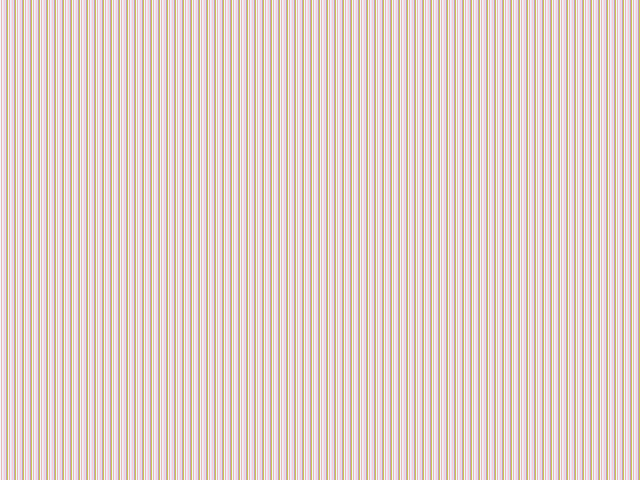

In [11]:
%matplotlib notebook
import matplotlib.pylab as plt
plt.figure()
plt.plot(trace_array[2], 'orange')
#plt.plot(trace_array[4], 'g')
plt.show()

# T-Test

### Helper Functions

In [12]:
def mean(n):
    n[np.isnan(n)]  = 0
    return n.mean(0)

def var(n):
    n[np.isnan(n)] = 0
    return n.var(0)

def ttest(a,b,c,d,e,f):
    t = (a-b)/((c/e + d/f)**0.5)
    return t


### Tracing

<IPython.core.display.Javascript object>


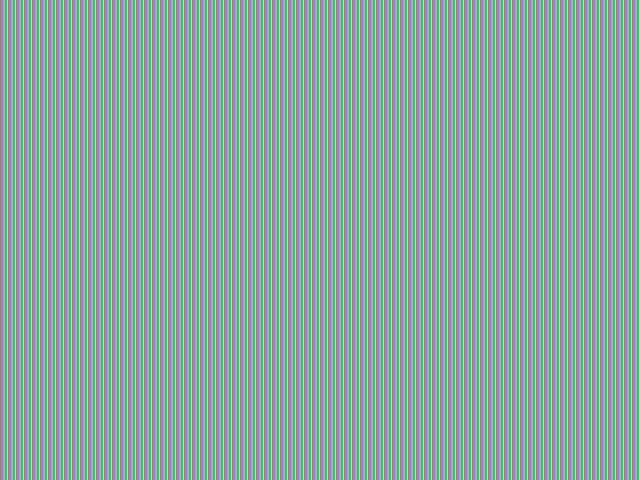

In [13]:
%matplotlib notebook
import matplotlib.pylab as plt
f1 = trace_array.shape[0]

a1 = mean(trace_array)
c1 = var(trace_array)

b1 = mean(trace_array_mean)
d1 = var(trace_array_mean)

t = ttest(a1, b1, c1, d1, f1, f1)

plt.plot(t)
plt.plot([4.5] * scope.adc.samples, color="red")
plt.plot([-4.5] * scope.adc.samples, color="red")
plt.show()
